In [2]:
TRAIN_PATH = '/kaggle/input/machinehackweekendinsurancechurnprediction/Insurance_Churn_ParticipantsData/Train.csv'
TEST_PATH = '/kaggle/input/machinehackweekendinsurancechurnprediction/Insurance_Churn_ParticipantsData/Test.csv'
SAMPLE_SUB_PATH = '/kaggle/input/machinehackweekendinsurancechurnprediction/Insurance_Churn_ParticipantsData/sample_submission.xlsx'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
import datetime
import time
from tqdm import tqdm_notebook
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
OUTPUT_FILE_PREFIX = 'machinehack_weekend_insurance_prediction_lgbm_v13'

def custom_metric(y_true, y_pred):
    return f'F1_score: {f1_score(y_true, np.round(y_pred))}'

N_FOLDS = 5

In [5]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_excel(SAMPLE_SUB_PATH)

ID_COL, TARGET_COL = '_', 'labels'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [6]:
TARGET_COL

'labels'

In [7]:
print(f"Train Shape: {train.shape}, Test shape: {test.shape}")
print("\nTest to Train Percentage: {:.2f} %".format(100 * (test.shape[0]/train.shape[0])))

Train Shape: (33908, 17), Test shape: (11303, 16)

Test to Train Percentage: 33.33 %


In [8]:
df = pd.concat([train, test]).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [9]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]

In [10]:
df[features] = df[features].apply(lambda x: x + x.min())

In [11]:
df[[c + '_freq' for c in features]] = df[features].apply(lambda x: x.map(x.value_counts(normalize=True)))

In [13]:
df['f1'] = df.groupby(['feature_14'])['feature_1'].transform('mean')
df['f2'] = df.groupby(['feature_14'])['feature_3'].transform('mean')

In [14]:
df.nunique()

feature_0            77
feature_1          7168
feature_10            2
feature_11            2
feature_12            2
feature_13            3
feature_14           12
feature_15            4
feature_2            31
feature_3          1573
feature_4            48
feature_5           559
feature_6            41
feature_7            12
feature_8             3
feature_9             4
labels                2
feature_0_freq       69
feature_1_freq       73
feature_10_freq       2
feature_11_freq       2
feature_12_freq       2
feature_13_freq       3
feature_14_freq      12
feature_15_freq       4
feature_2_freq       31
feature_3_freq      164
feature_4_freq       36
feature_5_freq       67
feature_6_freq       26
feature_7_freq       12
feature_8_freq        3
feature_9_freq        4
f1                   12
f2                   12
dtype: int64

In [15]:
df['f7_15'] = pd.factorize(df['feature_14'].astype('str') + df['feature_2'].astype('str'))[0]

In [16]:
df['f_1-3'] = df['feature_1'] - df['feature_3']
df['f_1-3'][df['f_1-3'] < 0] = np.nan
df['f_14-7'] = df['feature_14'] - df['feature_7']
df['f_14-7'][df['f_14-7'] < 0] = np.nan

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
train, test = df[:train.shape[0]], df[train.shape[0]:]
target = train[TARGET_COL]
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [18]:
training_start_time = time.time()

max_iter = N_FOLDS
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(train))
preds_test = np.zeros(len(test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_test = test[features]
    
    print(X_trn.shape)
    
    clf = LGBMClassifier( n_estimators = 4000, learning_rate = 0.01, num_leaves=200, max_depth=4, colsample_by_tree =2, reg_alpha=0.5, reg_lambda=0.5, 
                        bagging_freq=1, bagging_fraction=0.8, max_bin=50)
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_trn, y_trn), (X_val, y_val)], eval_metric = 'f1', verbose = 100, early_stopping_rounds = 200)
    
    oofs[val_idx] = clf.predict_proba(X_val)[:, 1]
    current_test_pred = clf.predict_proba(X_test)[:, 1]
    preds_test += clf.predict_proba(X_test)[:, 1]/max_iter
    
    print(f'\n Fold {custom_metric(y_val, oofs[val_idx])}')

    fold_importance_df = pd.DataFrame({'feature': X_trn.columns.tolist(), 'importance': clf.feature_importances_})
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {custom_metric(target, oofs)}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

(27126, 37)
Training until validation scores don't improve for 200 rounds
[100]	training's binary_logloss: 0.251449	valid_1's binary_logloss: 0.251081
[200]	training's binary_logloss: 0.222992	valid_1's binary_logloss: 0.224012
[300]	training's binary_logloss: 0.21013	valid_1's binary_logloss: 0.212841
[400]	training's binary_logloss: 0.20211	valid_1's binary_logloss: 0.206858
[500]	training's binary_logloss: 0.196618	valid_1's binary_logloss: 0.203468
[600]	training's binary_logloss: 0.19206	valid_1's binary_logloss: 0.20095
[700]	training's binary_logloss: 0.188336	valid_1's binary_logloss: 0.199217
[800]	training's binary_logloss: 0.185134	valid_1's binary_logloss: 0.197977
[900]	training's binary_logloss: 0.18228	valid_1's binary_logloss: 0.196921
[1000]	training's binary_logloss: 0.179493	valid_1's binary_logloss: 0.195922
[1100]	training's binary_logloss: 0.177052	valid_1's binary_logloss: 0.195347
[1200]	training's binary_logloss: 0.174655	valid_1's binary_lo

[1800]	training's binary_logloss: 0.162334	valid_1's binary_logloss: 0.199636
[1900]	training's binary_logloss: 0.160691	valid_1's binary_logloss: 0.199577
[2000]	training's binary_logloss: 0.159072	valid_1's binary_logloss: 0.199476
[2100]	training's binary_logloss: 0.157487	valid_1's binary_logloss: 0.199485
[2200]	training's binary_logloss: 0.15601	valid_1's binary_logloss: 0.199345
[2300]	training's binary_logloss: 0.154429	valid_1's binary_logloss: 0.199227
[2400]	training's binary_logloss: 0.152957	valid_1's binary_logloss: 0.199214
[2500]	training's binary_logloss: 0.151521	valid_1's binary_logloss: 0.199382
Early stopping, best iteration is:
[2367]	training's binary_logloss: 0.153481	valid_1's binary_logloss: 0.199193

 Fold F1_score: 0.5258493353028065

->-> Fold ran for 0 minutes 18 seconds

---- Fold 4 -----

(27127, 37)
Training until validation scores don't improve for 200 rounds
[100]	training's binary_logloss: 0.250729	valid_1's binary_logloss: 0.251517
[200]	training's 

In [19]:
print(f'\nOOF val score: {custom_metric(target, (oofs > 0.28)*1)}')


OOF val score: F1_score: 0.6335016654131299


In [20]:
oofs_1 = oofs
preds_test_1 = preds_test

In [21]:
training_start_time = time.time()

max_iter = N_FOLDS
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(train))
preds_test = np.zeros(len(test))

# feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_test = test[features]
    
    print(X_trn.shape)
    
    clf = ExtraTreesClassifier(n_estimators=200, max_features=0.8, n_jobs=-1)
    _ = clf.fit(X_trn.fillna(-9999), y_trn)
    
    oofs[val_idx] = clf.predict_proba(X_val.fillna(-9999))[:, 1]
    current_test_pred = clf.predict_proba(X_test.fillna(-9999))[:, 1]
    preds_test += clf.predict_proba(X_test.fillna(-9999))[:, 1]/max_iter
    
    print(f'\n Fold {custom_metric(y_val, oofs[val_idx])}')

#     fold_importance_df = pd.DataFrame({'feature': X_trn.columns.tolist(), 'importance': clf.feature_importances_})
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {custom_metric(target, oofs)}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

(27126, 37)

 Fold F1_score: 0.5702306079664571

->-> Fold ran for 0 minutes 9 seconds

---- Fold 1 -----

(27126, 37)

 Fold F1_score: 0.545583038869258

->-> Fold ran for 0 minutes 9 seconds

---- Fold 2 -----

(27126, 37)

 Fold F1_score: 0.5437454808387563

->-> Fold ran for 0 minutes 18 seconds

---- Fold 3 -----

(27127, 37)

 Fold F1_score: 0.5204081632653061

->-> Fold ran for 0 minutes 16 seconds

---- Fold 4 -----

(27127, 37)

 Fold F1_score: 0.5505226480836237

->-> Fold ran for 0 minutes 8 seconds

OOF val score: F1_score: 0.5463331438317225

->-> Total training time: 1 minutes 2 seconds


In [22]:
print(f'\nOOF val score: {custom_metric(target, (oofs > 0.35)*1)}')


OOF val score: F1_score: 0.618968015156581


In [23]:
oofs_2 = oofs
preds_test_2 = preds_test

In [31]:
oofs = oofs_1 * 0.8 + oofs_2 * 0.2
preds_test = preds_test_1 * 0.8 + preds_test_2 * 0.2

In [32]:
print(f'\nOOF val score: {custom_metric(target, (oofs > 0.27)*1)}')


OOF val score: F1_score: 0.6369053842132776


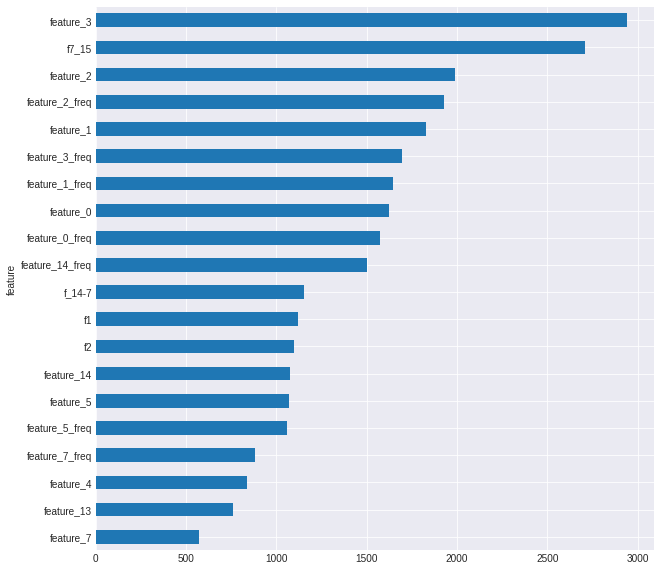

In [33]:
_ = plt.figure(figsize=(10, 10))
fi = feature_importance_df.groupby('feature')['importance'].mean()
_ = fi.sort_values()[-20:].plot.barh()

In [34]:
sample_sub

,labels
0,1
1,1
2,1
3,1
4,1
...,...
11298,1
11299,1
11300,1
11301,1


In [35]:
preds_df = pd.DataFrame()
preds_df[TARGET_COL] = ((preds_test > 0.27) * 1).astype('int')
preds_df.to_excel(OUTPUT_FILE_PREFIX + '_submission.xlsx', index=False)
preds_df.head(10)

,labels
0,1
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [36]:
preds_df['labels'].value_counts()

0    9441
1    1862
Name: labels, dtype: int64